# Introduction to NLP fundamentals

Common NLP problem is sequence to sequence (seq2seq).

In [1]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Visualizing a text dataset

In [2]:
# We want to predict whether the data is a disaster or not a disaster

In [3]:
import pandas as pd

train_df = pd.read_csv("../Datasets/nlp_getting_started/train.csv")
test_df = pd.read_csv("../Datasets/nlp_getting_started/test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle our traininig dataframe

train_df_shuffled = train_df.sample(frac=1, random_state=42) #frac is what percentage do we want to shuffle. 1=100%
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
#Let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _, text, target = row # "_" -> to get rid of index
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n {text} \n")
    print("---\n")

Target: 1 (real disaster)
Text:
 #bioterrorism Authorities allay #glanders fears ahead of Rio Olympic equestrian test event http://t.co/UotPNSQpz5 via @HorsetalkNZ 

---

Target: 1 (real disaster)
Text:
 Solitude Fire Update August 6 2015 (Solitude Wildfire): Summary: This lightning-caused fire is being ... http://t.co/4eSbsA8InT #UTFire 

---

Target: 0 (not real disaster)
Text:
 Some good info to help first responders cope- Individual Resilience: Factsheet for Responders- http://t.co/FcFpijiqt5 

---

Target: 1 (real disaster)
Text:
 THE NATIONAL WEATHER SERVICE IN LITTLE ROCK HAS ISSUED A * SEVERE THUNDERSTORM WARNING FOR... VAN BUREN COUNTY IN Û_ http://t.co/KJsvW06GBV 

---

Target: 1 (real disaster)
Text:
 Refugio oil spill may have been costlier bigger than projected http://t.co/BIEYgUqpB1 

---



### Split data into Training and Validation set

In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1, #10% for validation set
                                                                            random_state = 42)

In [11]:
# Check lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting Text into Numbers

### Tokenization
Direct mapping of token (word or character) to a number

In [13]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Default parameters:

text_vectorizer = TextVectorization(max_tokens= None, # how many words in the vocabulary
                                    standardize= "lower_and_strip_punctuation",
                                    split= "whitespace",
                                    ngrams= None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens = False)

2024-09-26 22:06:06.265934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-26 22:06:06.265952: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-26 22:06:06.265961: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-26 22:06:06.265973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-26 22:06:06.265985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
# Find the average number of tokens (words) in the training tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# Setup text vectorization variables

max_vocab_length = 10000
max_length = 15 # How many words of a tweet does a model see

text_vectorizer = TextVectorization(max_tokens= max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [17]:
# Fit the TextVectorizer to the training text

text_vectorizer.adapt(train_sentences)

In [18]:
# Create a sample sentence and tokenize it
sample_sentece = "There's a flood in my street!"
text_vectorizer([sample_sentece])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training set

random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\n Vectorized version:")
text_vectorizer(random_sentence)

Original text:
 New print available on http://t.co/ucy5fEA9yu! - 'Waiting Too Long' by Pamela Blizzard - http://t.co/dnwwo1YbRK      

 Vectorized version:


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([  50, 2783, 6153,   11,    1, 1572,  150,  480,   18,  933,  863,
          1,    0,    0,    0])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [21]:
top_5_words, bottom_5_words

(['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

In [22]:
# This way of using TextVectorization is a naive way. Let's try a better way

## Creating an Embedding using the Embedding Layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                            output_dim = 128, 
                            #  input_length = max_length # deprecated
                            )
embedding

<Embedding name=embedding, built=False>

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence} \
    \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer(random_sentence))
sample_embed

Original text:
 @Grazed @invalid @Stretcher @Rexyy @Towel 'Ben favorited'     

Embedded version:


<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
array([[ 0.04440966,  0.04035748, -0.03425775, ...,  0.04613693,
         0.00460682, -0.03713459],
       [-0.02983394, -0.01872295, -0.02905468, ..., -0.04515157,
        -0.03710056,  0.02532374],
       [ 0.04855846,  0.04256144,  0.02929202, ...,  0.02690384,
        -0.04964961, -0.02475289],
       ...,
       [-0.01555418, -0.03149681,  0.03663227, ..., -0.04846373,
        -0.02511554,  0.00250017],
       [-0.01555418, -0.03149681,  0.03663227, ..., -0.04846373,
        -0.02511554,  0.00250017],
       [-0.01555418, -0.03149681,  0.03663227, ..., -0.04846373,
        -0.02511554,  0.00250017]], dtype=float32)>

In [25]:
# Check out a single token's embedding

sample_embed[0], sample_embed[0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 4.4409659e-02,  4.0357482e-02, -3.4257747e-02, -2.6775276e-02,
         3.5862301e-02,  3.5495330e-02, -5.0207227e-04,  1.1695623e-02,
        -2.4817182e-02, -3.7159324e-02,  4.4824097e-02, -2.5200272e-02,
        -3.4961499e-02, -1.7832626e-02,  2.3098920e-02,  3.9790872e-02,
         2.4305370e-02,  1.1101425e-02, -1.0556854e-02, -2.9500592e-02,
         1.9804802e-02, -4.6671867e-02, -1.4954470e-02, -9.5108040e-03,
        -4.4541098e-02,  2.0171825e-02, -1.2914110e-02, -2.4466291e-03,
        -2.2039302e-03,  2.5933061e-02,  1.4144890e-03,  4.4145320e-02,
         4.1650664e-02,  3.7073899e-02,  4.4013858e-03,  1.4059816e-02,
         6.0377829e-03,  1.7926041e-02, -4.0060449e-02,  2.3700383e-02,
        -2.6922977e-02,  3.9647222e-03,  1.1794649e-02, -3.3730783e-02,
         1.2084447e-02,  1.0367524e-02,  4.1672956e-02,  1.8873066e-04,
        -3.7439693e-02, -2.5285244e-02,  1.7964158e-02, -4.4170845e-02,
         2.4890

## Modelling a text dataset (running a series of experiments)

### Model 0: Getting a Baseline -> SKLearn's Naive Bayes using the TF-IDF formula.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling Pipeline
model_0 = Pipeline([    ("tfidf", TfidfVectorizer()), # convert words to numbers using TFIDF
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [29]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating a function to evaluation our Model's experiments
* Accuracy
* Precision
* Recall
* F1-score

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates the model's accuracy, precions, recall, and f1 score of a binary classification model.
    """
    
    # Calculate model accuracy:
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate the other 3:
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [31]:
# Get baseline results:
baseline_results = calculate_results(y_true=val_labels,y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 0: Feed-forward NN Dense Model

In [32]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoar logs
SAVE_DIR = "NLP_models_logs/model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn text into numbers
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x) # reduce the extra dimension given my the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # Sigmoid activation for binary outputs
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
model_1_history = model_1.fit(x = train_sentences,
                              y = train_labels,
                              epochs = 5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, experiment_name="model_1_dense")]
                              )

Saving TensorBoard log files to: NLP_models_logs/model_logs/model_1_dense/20240926-220606
Epoch 1/5


2024-09-26 22:06:07.009020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6457 - loss: 0.6471 - val_accuracy: 0.7664 - val_loss: 0.5326
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8130 - loss: 0.4594 - val_accuracy: 0.7861 - val_loss: 0.4721
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8603 - loss: 0.3517 - val_accuracy: 0.7966 - val_loss: 0.4574
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8870 - loss: 0.2884 - val_accuracy: 0.7861 - val_loss: 0.4797
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9103 - loss: 0.2419 - val_accuracy: 0.7835 - val_loss: 0.4803


In [37]:
# Check the results

model_1.evaluate(val_sentences,val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.5115


[0.48025527596473694, 0.7834645509719849]

In [38]:
# Make predictions and evaluate our results
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.40144917],
       [0.82895184],
       [0.99747235],
       [0.13433957],
       [0.11096589],
       [0.9379123 ],
       [0.9269008 ],
       [0.99193984],
       [0.95985657],
       [0.31312156]], dtype=float32)

In [39]:
# Convert model predictions probabilities to label format

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs[:]))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [40]:
# Calculate our model 1's results

model_1_results = calculate_results(y_true= val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7834645669291339,
 'precision': 0.7880043492637875,
 'recall': 0.7834645669291339,
 'f1': 0.7804929895574078}

In [41]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [42]:
import numpy as np
np.array(list(baseline_results.values())) > np.array(list(model_1_results.values()))

array([ True,  True,  True,  True])

In [43]:
# Model 1 did not perform better than our simple baseline.

## Visualizing learned embeddings

In [44]:
# Get the vocabulary from the text vectorization layer
words_in_vocabulary = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [46]:
# Get the weight matrix of the embedding layer. These are numerical representations of each token in our training data

embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [47]:
# let's see how we can visualize these tokens/embeddings. Let's use the Projector provided by tensorflow.
# Create embedding files (from Tensorflow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

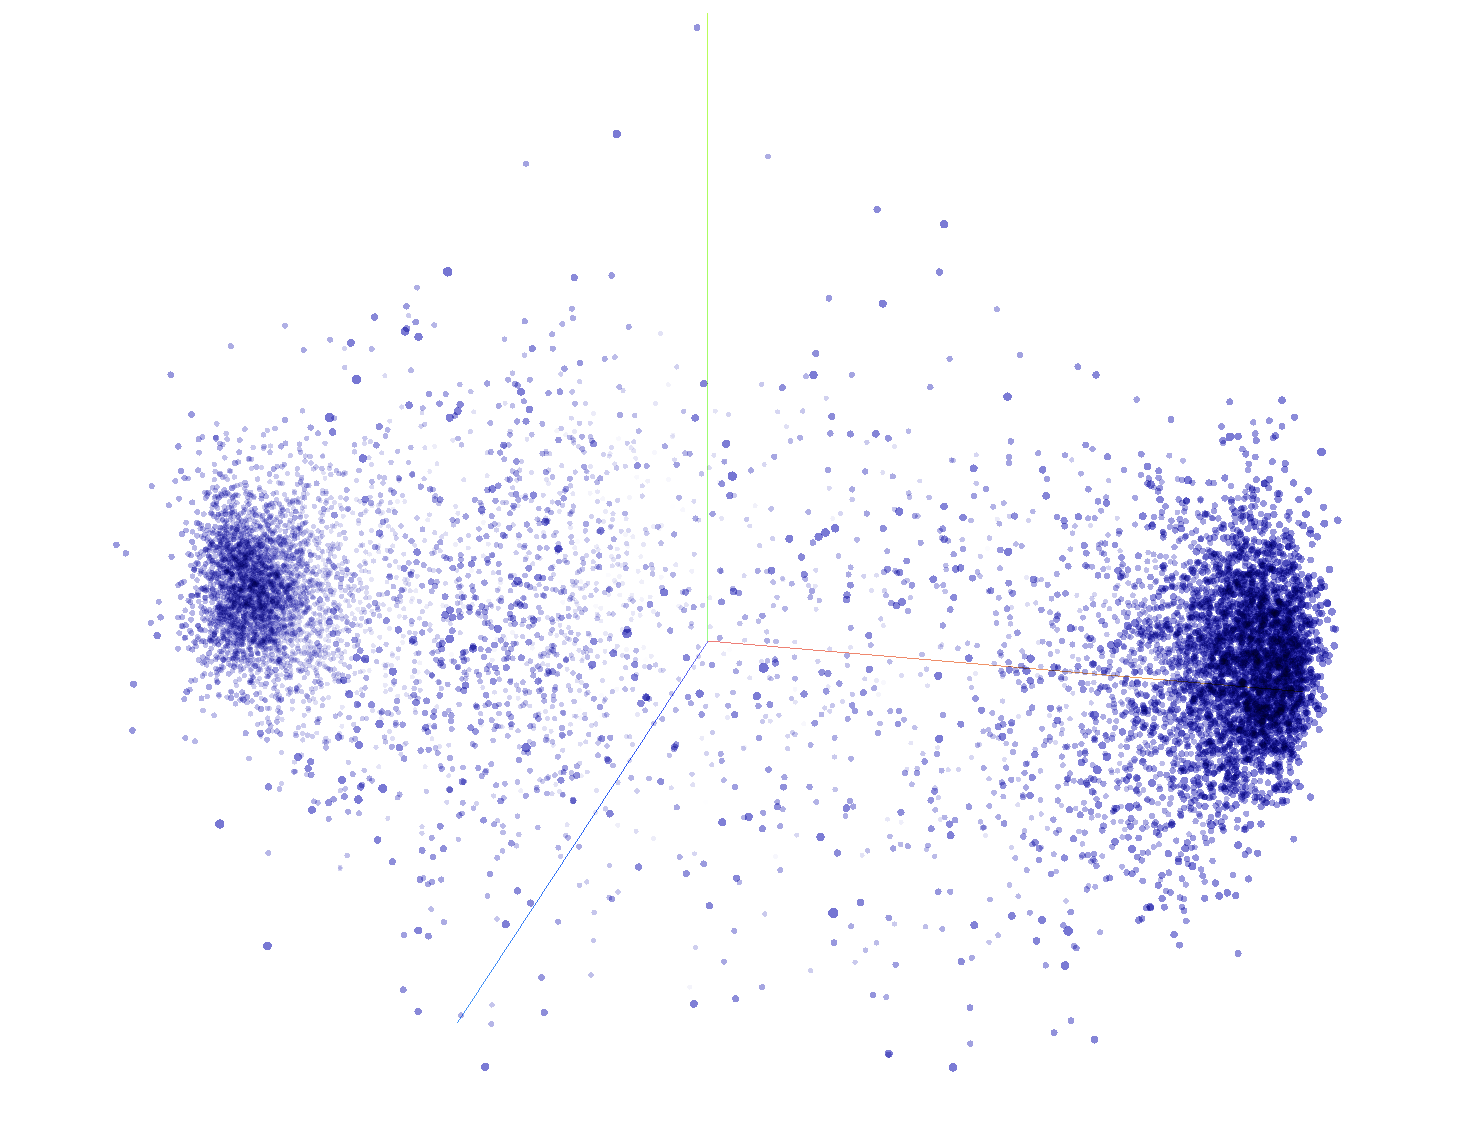

In [48]:
# We are using these files (vectors and metadata) to visualize them in: https://projector.tensorflow.org/

from IPython.display import Image

# Display the image
Image(filename='tensorflow_projector.png')

## Recurrent Neural Networks

### Model 2: LSTM

Typical structure of an RNN: 
Input (text) -> Tokenizer -> Embedding -> Layers (RNNs/Dense) -> Output (label probability)

In [67]:
# Create an LSTM model

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)

# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)

x = layers.LSTM(64)(x)
# print(x.shape)

# outputs = layers.Dense(64, activation="relu")(x)
# print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs, name="model_2_LSTM")

In [68]:
# Get a summary

model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Compile the model

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [70]:
# Fit the model

model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: NLP_models_logs/model_logs/model_2_LSTM/20240926-221742
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9408 - loss: 0.2360 - val_accuracy: 0.7612 - val_loss: 0.6627
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9754 - loss: 0.0913 - val_accuracy: 0.7769 - val_loss: 0.6856
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9746 - loss: 0.0831 - val_accuracy: 0.7664 - val_loss: 0.7613
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9788 - loss: 0.0649 - val_accuracy: 0.7703 - val_loss: 1.0596
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9792 - loss: 0.0591 - val_accuracy: 0.7651 - val_loss: 0.8875


In [71]:
# Make predictions with LSTM model

model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[0.0263135 ],
       [0.74448466],
       [0.9993801 ],
       [0.10328265],
       [0.00127501],
       [0.99887246],
       [0.9847221 ],
       [0.99935323],
       [0.9960829 ],
       [0.07199341]], dtype=float32)

In [73]:
# Convert model 2 pred probs to labels

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [74]:
# Calculate Model's 2 results

model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 0.7650918635170604,
 'precision': 0.7672217903358366,
 'recall': 0.7650918635170604,
 'f1': 0.7626195388168748}

In [75]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}